# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib# Importb.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
import sklearn
import sklearn.preprocessing
import datetime
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import warnings
warnings.filterwarnings(action='ignore')

Instructions for updating:
non-resource variables are not supported in the long term


# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
path = "input/"

# original data : data 
data =  pd.read_csv(path + "demential_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터  
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 나눌 수 있겠습니다. 

**4. converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 5 columns**

**===================Default 하게 진행======================**

RNN, LSTM 모델에서는 converting features 사용할 예정  
각각의 converting data가 가지는 길이가 다르기 때문에 sig1, sig2, sig3... sig5 data로 나누어 사용할 것  

**feature processing**
- astype : float 
- sig1_data, sig2_data, sig3_data, sig4_data, sig5_data 
    - CONVERT(activity_class_5min USING utf8)    
    - CONVERT(activity_met_1min USING utf8)      
    - CONVERT(sleep_hr_5min USING utf8)          
    - CONVERT(sleep_hypnogram_5min USING utf8)  
    - CONVERT(sleep_rmssd_5min USING utf8) 

**=========================Y Varible=========================**

- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding 
    - 모델마다 y 변수를 자동으로 label encoding 기능을 지원하기도 하지만 공통적으로 진행하고 넘어갑시다
    
So we may use 5 columns for training...

In [5]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = data.copy()

In [6]:
# Feature Selection - column drop 
# 사용할 column만 잘라냅니다
processed_data = processed_data.iloc[:, 60:66]
# 9327 x 6 

processed_data -> 5개의 sig1_data, sig2_data, sig3_data, sig4_data, sig5_data 으로 변환

In [7]:
# signal 01
signal_list = list(processed_data['CONVERT(activity_class_5min USING utf8)'].str.split('/'))
sig1_data = pd.DataFrame(signal_list).drop(288, axis=1).astype('float')

sig1_data # 9327 x 288

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9323,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9324,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9325,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
# signal 02
signal_list = list(processed_data['CONVERT(activity_met_1min USING utf8)'].str.split('/'))
sig2_data = pd.DataFrame(signal_list).drop(1440, axis=1).astype('float')

sig2_data # 9327 x 1440

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.9,0.9,1.4,1.9,1.1,0.9,0.9,1.1,1.3,1.0,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,1.2,1.1,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,1.1,1.1,1.2,1.1,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.1,1.4,1.2,0.9,1.2,1.1,0.9,0.9,0.9,1.0,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9323,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9324,0.9,0.9,0.9,0.9,1.1,0.9,0.9,1.1,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9325,1.1,0.9,0.9,0.9,1.0,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [9]:
# signal 03
signal_list = list(processed_data['CONVERT(sleep_hr_5min USING utf8)'].str.split('/'))
sig3_data = pd.DataFrame(signal_list).drop(181, axis=1).transpose() # 결측치 처리를 위한 transpose 

# 결측치 처리 Nan, '', ' ' -> 0으로 replace 
sig3_data = sig3_data.fillna(0) 
sig3_data = sig3_data.replace('', 0)
sig3_data = sig3_data.replace(' ', 0)
sig3_data = sig3_data.astype('float').transpose() # 되돌리기 

sig3_data # 9327 x 181

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.0,73.0,73.0,73.0,72.0,71.0,70.0,71.0,71.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69.0,70.0,69.0,69.0,70.0,72.0,71.0,72.0,70.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,74.0,73.0,73.0,74.0,74.0,74.0,71.0,71.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.0,70.0,71.0,72.0,75.0,75.0,73.0,70.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,0.0,54.0,54.0,54.0,55.0,56.0,0.0,0.0,55.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9323,68.0,66.0,67.0,67.0,68.0,69.0,69.0,70.0,71.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,0.0,0.0,65.0,65.0,66.0,67.0,69.0,72.0,73.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,0.0,0.0,0.0,64.0,64.0,64.0,64.0,65.0,65.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# signal 04
signal_list = list(processed_data['CONVERT(sleep_hypnogram_5min USING utf8)'].str.split('/'))
sig4_data = pd.DataFrame(signal_list).drop(180, axis=1).transpose() # 결측치 처리를 위한 transpose 

# 결측치 처리 Nan, '', ' ' -> 0으로 replace 
sig4_data = sig4_data.fillna(0) 
sig4_data = sig4_data.replace('', 0)
sig4_data = sig4_data.replace(' ', 0)
sig4_data = sig4_data.astype('float').transpose() # 되돌리기 

sig4_data # 9327 x 180

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,4.0,2.0,4.0,3.0,3.0,1.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,4.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,2.0,4.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,4.0,4.0,4.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9323,4.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,4.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# signal 05
signal_list = list(processed_data['CONVERT(sleep_rmssd_5min USING utf8)'].str.split('/'))
sig5_data = pd.DataFrame(signal_list).drop(181, axis=1).transpose() # 결측치 처리를 위한 transpose 

# 결측치 처리 Nan, '', ' ' -> 0으로 replace 
sig5_data = sig5_data.fillna(0) 
sig5_data = sig5_data.replace('', 0)
sig5_data = sig5_data.replace(' ', 0)
sig5_data = sig5_data.astype('float').transpose() # 되돌리기 

sig5_data # 9327 x 181

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.0,10.0,10.0,10.0,11.0,11.0,10.0,12.0,18.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.0,23.0,26.0,24.0,18.0,13.0,15.0,14.0,17.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,11.0,14.0,20.0,13.0,14.0,14.0,16.0,27.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24.0,28.0,19.0,17.0,12.0,10.0,17.0,20.0,23.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,0.0,35.0,39.0,28.0,26.0,41.0,0.0,0.0,52.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9323,26.0,16.0,19.0,18.0,16.0,18.0,19.0,17.0,15.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,0.0,0.0,13.0,12.0,12.0,13.0,12.0,12.0,12.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,0.0,0.0,0.0,14.0,17.0,18.0,14.0,14.0,17.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Data Split + y Variable Processing 

모든 전처리와 y variable labeling이 완료되었다.  
train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자.

- **3d - array 처리** 
    - Sequential model 의 input layer에는 ndarray 데이터만 들어가야 함
- **y 변수 두 가지로 encoding** 
    - Label Encoding (le) -> sparse_categorical_crossentropy 실험 
    - One Hot Encoding (ohe) -> categorical_crossentropy 실험 
- **train / test** 
    - Sequential model option 중 validation dataset을 자동으로 나눠주는 것이 존재 하므로 


- 즉 다음과 같은 조합이 하나의 dataset 이며  
    - input_data_X1 + input_data_y_le + input_data_y_ohe
    - 실험은 한 모델당 두 가지 y 변수로 2번 실험하면 됨
    - **inpu_data_X1_le + input_data_y_le**
    - **inpu_data_X1_ohe + input_data_y_ohe**

In [12]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# data를 따로 관리
# preprocessing data -> processed_data
# input data -> input_data => y 변수와 X 변수 분할 관리 
input_data_X1 = sig1_data.copy()
input_data_X2 = sig2_data.copy()
input_data_X3 = sig3_data.copy()
input_data_X4 = sig4_data.copy()
input_data_X5 = sig5_data.copy()

input_data_y = processed_data['DIAG_NM'] .copy()

In [13]:
# 3d-array 처리 - X variables 
input_data_X1 =  input_data_X1.to_numpy().reshape(input_data_X1.shape[0], input_data_X1.shape[1], 1)
input_data_X2 =  input_data_X2.to_numpy().reshape(input_data_X2.shape[0], input_data_X2.shape[1], 1)
input_data_X3 =  input_data_X3.to_numpy().reshape(input_data_X3.shape[0], input_data_X3.shape[1], 1)
input_data_X4 =  input_data_X4.to_numpy().reshape(input_data_X4.shape[0], input_data_X4.shape[1], 1)
input_data_X5 =  input_data_X5.to_numpy().reshape(input_data_X5.shape[0], input_data_X5.shape[1], 1)

In [14]:
# LabelEncoder - y variable 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y_label = le.fit_transform(list(input_data_y))

print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y_label))

input_data_y_label

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
# One Hot Encdoer - y variable 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

input_data_y.shape
input_data_y.values.reshape(-1,1).shape
ohe.fit(input_data_y.values.reshape(-1,1))
one_hot_encoded = ohe.transform(input_data_y.values.reshape(-1,1))

print(type(ohe.categories_))
print(ohe.categories_)

input_data_y_ohe = pd.DataFrame(one_hot_encoded, columns=ohe.categories_[0])
input_data_y_ohe

<class 'list'>
[array(['CN', 'Dem', 'MCI'], dtype=object)]


,CN,Dem,MCI
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
9322,1.0,0.0,0.0
9323,1.0,0.0,0.0
9324,1.0,0.0,0.0
9325,1.0,0.0,0.0


In [16]:
X1_train_label, X1_test_label, y1_train_label, y1_test_label = train_test_split(
    input_data_X1, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X2_train_label, X2_test_label, y2_train_label, y2_test_label = train_test_split(
    input_data_X2, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X3_train_label, X3_test_label, y3_train_label, y3_test_label = train_test_split(
    input_data_X3, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X4_train_label, X4_test_label, y4_train_label, y4_test_label = train_test_split(
    input_data_X4, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X5_train_label, X5_test_label, y5_train_label, y5_test_label = train_test_split(
    input_data_X5, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)

In [17]:
X1_train_ohe, X1_test_ohe, y1_train_ohe, y1_test_ohe = train_test_split(
    input_data_X1, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X2_train_ohe, X2_test_ohe, y2_train_ohe, y2_test_ohe = train_test_split(
    input_data_X2, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X3_train_ohe, X3_test_ohe, y3_train_ohe, y3_test_ohe = train_test_split(
    input_data_X3, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X4_train_ohe, X4_test_ohe, y4_train_ohe, y4_test_ohe = train_test_split(
    input_data_X4, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X5_train_ohe, X5_test_ohe, y5_train_ohe, y5_test_ohe = train_test_split(
    input_data_X5, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)

In [18]:
# 데이터가 잘 분할되었을까요?
# 잘 분할되었습니다 
# 7461 + 1866 = 9327
print("X1_train_label :" ,X1_train_label.shape)
print("X1_train_ohe :" ,X1_train_ohe.shape)
print("y1_train_label :" ,y1_train_label.shape)
print("y1_train_ohe :" ,y1_train_ohe.shape)
print("X1_test_label :" ,X1_test_label.shape)
print("X1_test_ohe :" ,X1_test_ohe.shape)
print("y1_test_label :" ,y1_test_label.shape)
print("y1_test_ohe :" ,y1_test_ohe.shape)

X1_train_label : (7461, 288, 1)
X1_train_ohe : (7461, 288, 1)
y1_train_label : (7461,)
y1_train_ohe : (7461, 3)
X1_test_label : (1866, 288, 1)
X1_test_ohe : (1866, 288, 1)
y1_test_label : (1866,)
y1_test_ohe : (1866, 3)


# 5. Modeling - DL 

- **simple RNN** 
    - ohe **0.638**
    - le **0.639**
- **multi-layer RNN**
    - ohe 0.637
    - le 0.637
- **simple LSTM**
    - ohe 
    - le 
- **multi-layer LSTM**
    - ohe 
    - le 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Activation, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from keras import optimizers
from sklearn.metrics import accuracy_score
from keras.layers import Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

In [20]:
# hyperparameters
units = 50
timesteps = 1
inputs = (X3_train_ohe.shape[1],X3_train_ohe.shape[2])
outputs = 3
epochs = 1000
batch_size = 256
# early_stop 하기 위해 관찰 값 monitor
# 관찰 값이 loss 이므로 최소화 시키는 방향으로 training이 진행 (default 깂 Auto)
# patience : 성능이 증가하지 않더라도 epoch을 얼마나 더 진행해볼 것인가?
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min'
                               , patience=100, verbose=1)

### simple RNN

In [21]:
def vanilla_rnn_ohe():
    model = Sequential()
    model.add(SimpleRNN(units, input_shape = inputs, return_sequences = False)) 
    model.add(Dense(outputs)) #target 개수 = 3
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    #y를 one-hot encoding 시 'categorical_crossentropy 사용
    #y를 label encoding 시 'sparse_categorical_crossentropy' 사용
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy']) 
    
    return model

In [22]:
# one-hot encoding으로 fit
signle_rnn_model_ohe = KerasClassifier(build_fn = vanilla_rnn_ohe
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
hist = signle_rnn_model_ohe.fit(X3_train_ohe, y3_train_ohe)
y3_pred_rnn_ohe = signle_rnn_model_ohe.predict(X3_test_ohe)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 1s 140us/sample - loss: 0.8827 - acc: 0.6160 - val_loss: 0.8314 - val_acc: 0.6450
Epoch 2/1000
5968/5968 [==============================] - 1s 122us/sample - loss: 0.8314 - acc: 0.6376 - val_loss: 0.8273 - val_acc: 0.6450
Epoch 3/1000
5968/5968 [==============================] - 1s 122us/sample - loss: 0.8263 - acc: 0.6376 - val_loss: 0.8286 - val_acc: 0.6450
Epoch 4/1000
5968/5968 [==============================] - 1s 121us/sample - loss: 0.8268 - acc: 0.6384 - val_loss: 0.8273 - val_acc: 0.6457
Epoch 5/1000
5968/5968 [==============================] - 1s 121us/sample - loss: 0.8252 - acc: 0.6389 - val_loss: 0.8259 - val_acc: 0.6457
Epoch 6/1000
5968/5968 [==============================] - 1s 120us/sample - loss: 0.8353 - acc: 0.6344 - val_loss: 0.8274 - val_acc: 0.6443
Epoch 7/1000
5968/5968 [==============================] - 1s 120us/sample - loss: 0.8258 - acc: 0.6389 - val_los

Epoch 59/1000
5968/5968 [==============================] - 1s 123us/sample - loss: 0.8259 - acc: 0.6396 - val_loss: 0.8268 - val_acc: 0.6457
Epoch 60/1000
5968/5968 [==============================] - 1s 124us/sample - loss: 0.8242 - acc: 0.6396 - val_loss: 0.8267 - val_acc: 0.6457
Epoch 61/1000
5968/5968 [==============================] - 1s 123us/sample - loss: 0.8248 - acc: 0.6396 - val_loss: 0.8269 - val_acc: 0.6457
Epoch 62/1000
5968/5968 [==============================] - 1s 124us/sample - loss: 0.8245 - acc: 0.6396 - val_loss: 0.8266 - val_acc: 0.6457
Epoch 63/1000
5968/5968 [==============================] - 1s 123us/sample - loss: 0.8243 - acc: 0.6397 - val_loss: 0.8265 - val_acc: 0.6457
Epoch 64/1000
5968/5968 [==============================] - 1s 125us/sample - loss: 0.8251 - acc: 0.6397 - val_loss: 0.8278 - val_acc: 0.6457
Epoch 65/1000
5968/5968 [==============================] - 1s 123us/sample - loss: 0.8243 - acc: 0.6396 - val_loss: 0.8264 - val_acc: 0.6457
Epoch 66/1000

Epoch 117/1000
5968/5968 [==============================] - 1s 124us/sample - loss: 0.8219 - acc: 0.6401 - val_loss: 0.8246 - val_acc: 0.6463
Epoch 118/1000
5968/5968 [==============================] - 1s 124us/sample - loss: 0.8206 - acc: 0.6399 - val_loss: 0.8254 - val_acc: 0.6457
Epoch 119/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8226 - acc: 0.6396 - val_loss: 0.8249 - val_acc: 0.6457
Epoch 120/1000
5968/5968 [==============================] - 1s 124us/sample - loss: 0.8225 - acc: 0.6396 - val_loss: 0.8268 - val_acc: 0.6463
Epoch 121/1000
5968/5968 [==============================] - 1s 122us/sample - loss: 0.8222 - acc: 0.6397 - val_loss: 0.8241 - val_acc: 0.6463
Epoch 121: early stopping


In [23]:
print("RNN accouracy : ", accuracy_score(y3_pred_rnn_ohe,y3_test_label))

RNN accouracy :  0.6377277599142551


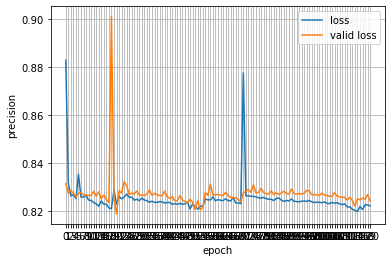

In [24]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.xticks(range(len(hist.history['loss'])))
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [25]:
def vanilla_rnn_label():
    model = Sequential()
    model.add(SimpleRNN(units, input_shape = inputs, return_sequences = False)) 
    model.add(Dense(outputs)) #target 개수 = 3
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    #y를 one-hot encoding 시 'categorical_crossentropy 사용
    #y를 label encoding 시 'sparse_categorical_crossentropy' 사용
    model.compile(loss='sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy']) 
    
    return model

In [26]:
# label encoding으로 fit
signle_rnn_model_label = KerasClassifier(build_fn = vanilla_rnn_label
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])

In [27]:
# label encoding으로 fit
signle_rnn_model_label.fit(X3_train_label, y3_train_label)
y3_pred_rnn_label = signle_rnn_model_label.predict(X3_test_label)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 1s 144us/sample - loss: 0.8602 - acc: 0.6233 - val_loss: 0.8322 - val_acc: 0.6463
Epoch 2/1000
5968/5968 [==============================] - 1s 130us/sample - loss: 0.8246 - acc: 0.6389 - val_loss: 0.8247 - val_acc: 0.6463
Epoch 3/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.8285 - acc: 0.6359 - val_loss: 0.8229 - val_acc: 0.6470
Epoch 4/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.8218 - acc: 0.6394 - val_loss: 0.8183 - val_acc: 0.6470
Epoch 5/1000
5968/5968 [==============================] - 1s 129us/sample - loss: 0.8235 - acc: 0.6377 - val_loss: 0.8228 - val_acc: 0.6470
Epoch 6/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.8204 - acc: 0.6397 - val_loss: 0.8627 - val_acc: 0.6470
Epoch 7/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.8270 - acc: 0.6396 - val_los

Epoch 59/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8078 - acc: 0.6402 - val_loss: 0.8001 - val_acc: 0.6457
Epoch 60/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8074 - acc: 0.6397 - val_loss: 0.8001 - val_acc: 0.6463
Epoch 61/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8078 - acc: 0.6402 - val_loss: 0.8016 - val_acc: 0.6463
Epoch 62/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8078 - acc: 0.6408 - val_loss: 0.7984 - val_acc: 0.6463
Epoch 63/1000
5968/5968 [==============================] - 1s 125us/sample - loss: 0.8072 - acc: 0.6406 - val_loss: 0.8029 - val_acc: 0.6463
Epoch 64/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8089 - acc: 0.6406 - val_loss: 0.7981 - val_acc: 0.6463
Epoch 65/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8075 - acc: 0.6396 - val_loss: 0.8008 - val_acc: 0.6463
Epoch 66/1000

Epoch 117/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.8039 - acc: 0.6399 - val_loss: 0.7974 - val_acc: 0.6450
Epoch 118/1000
5968/5968 [==============================] - 1s 126us/sample - loss: 0.8039 - acc: 0.6411 - val_loss: 0.7985 - val_acc: 0.6463
Epoch 119/1000
5968/5968 [==============================] - 1s 127us/sample - loss: 0.8041 - acc: 0.6411 - val_loss: 0.7994 - val_acc: 0.6450
Epoch 120/1000
5968/5968 [==============================] - 1s 127us/sample - loss: 0.8033 - acc: 0.6409 - val_loss: 0.8036 - val_acc: 0.6450
Epoch 121/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.8034 - acc: 0.6408 - val_loss: 0.7962 - val_acc: 0.6450
Epoch 122/1000
5968/5968 [==============================] - 1s 127us/sample - loss: 0.8056 - acc: 0.6404 - val_loss: 0.7971 - val_acc: 0.6457
Epoch 123/1000
5968/5968 [==============================] - 1s 129us/sample - loss: 0.8040 - acc: 0.6404 - val_loss: 0.7997 - val_acc: 0.6450
Epoch 

Epoch 175/1000
5968/5968 [==============================] - 1s 129us/sample - loss: 0.8008 - acc: 0.6421 - val_loss: 0.7981 - val_acc: 0.6470
Epoch 176/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.8015 - acc: 0.6416 - val_loss: 0.7969 - val_acc: 0.6450
Epoch 177/1000
5968/5968 [==============================] - 1s 129us/sample - loss: 0.8016 - acc: 0.6423 - val_loss: 0.7976 - val_acc: 0.6463
Epoch 178/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.7994 - acc: 0.6413 - val_loss: 0.7950 - val_acc: 0.6457
Epoch 179/1000
5968/5968 [==============================] - 1s 129us/sample - loss: 0.7994 - acc: 0.6419 - val_loss: 0.8058 - val_acc: 0.6463
Epoch 180/1000
5968/5968 [==============================] - 1s 129us/sample - loss: 0.8020 - acc: 0.6413 - val_loss: 0.7959 - val_acc: 0.6457
Epoch 181/1000
5968/5968 [==============================] - 1s 128us/sample - loss: 0.7988 - acc: 0.6414 - val_loss: 0.7964 - val_acc: 0.6463
Epoch 

Epoch 233/1000
5968/5968 [==============================] - 1s 140us/sample - loss: 0.8067 - acc: 0.6406 - val_loss: 0.7961 - val_acc: 0.6457
Epoch 234/1000
5968/5968 [==============================] - 1s 130us/sample - loss: 0.8064 - acc: 0.6402 - val_loss: 0.7950 - val_acc: 0.6450
Epoch 235/1000
5968/5968 [==============================] - 1s 139us/sample - loss: 0.8059 - acc: 0.6402 - val_loss: 0.7956 - val_acc: 0.6450
Epoch 236/1000
5968/5968 [==============================] - 1s 135us/sample - loss: 0.8066 - acc: 0.6409 - val_loss: 0.7946 - val_acc: 0.6457
Epoch 237/1000
5968/5968 [==============================] - 1s 142us/sample - loss: 0.8066 - acc: 0.6404 - val_loss: 0.7981 - val_acc: 0.6457
Epoch 238/1000
5968/5968 [==============================] - 1s 137us/sample - loss: 0.8078 - acc: 0.6404 - val_loss: 0.7965 - val_acc: 0.6457
Epoch 239/1000
5968/5968 [==============================] - 1s 141us/sample - loss: 0.8055 - acc: 0.6402 - val_loss: 0.7958 - val_acc: 0.6457
Epoch 

In [28]:
print("RNN accouracy : ", accuracy_score(y3_pred_rnn_label,y3_test_label))

RNN accouracy :  0.6355841371918542


### Mulit Layer RNN (One-hot encoding)

In [29]:
def stacked_vanilla_rnn_ohe():
    model = Sequential()
    # return_sequences parameter has to be set True to stack
    model.add(SimpleRNN(units, input_shape = inputs, return_sequences = True))   
    model.add(SimpleRNN(units, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [30]:
# one-hot encoding으로 fit
multi_rnn_model_ohe = KerasClassifier(build_fn = stacked_vanilla_rnn_ohe
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
multi_rnn_model_ohe.fit(X3_train_ohe, y3_train_ohe)
y3_pred_multi_rnn_ohe = multi_rnn_model_ohe.predict(X3_test_ohe)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 2s 323us/sample - loss: 0.8888 - acc: 0.5995 - val_loss: 0.8322 - val_acc: 0.6457
Epoch 2/1000
5968/5968 [==============================] - 2s 301us/sample - loss: 0.8254 - acc: 0.6391 - val_loss: 0.8277 - val_acc: 0.6457
Epoch 3/1000
5968/5968 [==============================] - 2s 299us/sample - loss: 0.8262 - acc: 0.6389 - val_loss: 0.8267 - val_acc: 0.6457
Epoch 4/1000
5968/5968 [==============================] - 2s 298us/sample - loss: 0.8256 - acc: 0.6391 - val_loss: 0.8340 - val_acc: 0.6450
Epoch 5/1000
5968/5968 [==============================] - 2s 300us/sample - loss: 0.8269 - acc: 0.6386 - val_loss: 0.8303 - val_acc: 0.6450
Epoch 6/1000
5968/5968 [==============================] - 2s 299us/sample - loss: 0.8239 - acc: 0.6401 - val_loss: 0.8266 - val_acc: 0.6450
Epoch 7/1000
5968/5968 [==============================] - 2s 295us/sample - loss: 0.8237 - acc: 0.6394 - val_los

Epoch 59/1000
5968/5968 [==============================] - 2s 303us/sample - loss: 0.8380 - acc: 0.6401 - val_loss: 0.8349 - val_acc: 0.6463
Epoch 60/1000
5968/5968 [==============================] - 2s 302us/sample - loss: 0.8288 - acc: 0.6397 - val_loss: 0.8346 - val_acc: 0.6470
Epoch 61/1000
5968/5968 [==============================] - 2s 300us/sample - loss: 0.8275 - acc: 0.6397 - val_loss: 0.8343 - val_acc: 0.6470
Epoch 62/1000
5968/5968 [==============================] - 2s 318us/sample - loss: 0.8248 - acc: 0.6402 - val_loss: 0.8298 - val_acc: 0.6470
Epoch 63/1000
5968/5968 [==============================] - 2s 315us/sample - loss: 0.8234 - acc: 0.6399 - val_loss: 0.8277 - val_acc: 0.6470
Epoch 64/1000
5968/5968 [==============================] - 2s 303us/sample - loss: 0.8210 - acc: 0.6404 - val_loss: 0.8255 - val_acc: 0.6470
Epoch 65/1000
5968/5968 [==============================] - 2s 300us/sample - loss: 0.8232 - acc: 0.6404 - val_loss: 0.8231 - val_acc: 0.6457
Epoch 66/1000

Epoch 117/1000
5968/5968 [==============================] - 2s 301us/sample - loss: 0.8023 - acc: 0.6424 - val_loss: 0.8040 - val_acc: 0.6477
Epoch 118/1000
5968/5968 [==============================] - 2s 311us/sample - loss: 0.8029 - acc: 0.6416 - val_loss: 0.8026 - val_acc: 0.6463
Epoch 119/1000
5968/5968 [==============================] - 2s 323us/sample - loss: 0.8020 - acc: 0.6419 - val_loss: 0.8083 - val_acc: 0.6457
Epoch 120/1000
5968/5968 [==============================] - 2s 336us/sample - loss: 0.8009 - acc: 0.6423 - val_loss: 0.8098 - val_acc: 0.6463
Epoch 121/1000
5968/5968 [==============================] - 2s 334us/sample - loss: 0.8011 - acc: 0.6426 - val_loss: 0.8054 - val_acc: 0.6463
Epoch 122/1000
5968/5968 [==============================] - 2s 339us/sample - loss: 0.8050 - acc: 0.6433 - val_loss: 0.8056 - val_acc: 0.6463
Epoch 123/1000
5968/5968 [==============================] - 2s 307us/sample - loss: 0.7996 - acc: 0.6436 - val_loss: 0.8062 - val_acc: 0.6477
Epoch 

Epoch 175/1000
5968/5968 [==============================] - 2s 325us/sample - loss: 0.8209 - acc: 0.6423 - val_loss: 0.8272 - val_acc: 0.6457
Epoch 176/1000
5968/5968 [==============================] - 2s 320us/sample - loss: 0.8184 - acc: 0.6418 - val_loss: 0.8187 - val_acc: 0.6463
Epoch 177/1000
5968/5968 [==============================] - 2s 323us/sample - loss: 0.8152 - acc: 0.6416 - val_loss: 0.8178 - val_acc: 0.6463
Epoch 178/1000
5968/5968 [==============================] - 2s 321us/sample - loss: 0.8148 - acc: 0.6411 - val_loss: 0.8184 - val_acc: 0.6463
Epoch 179/1000
5968/5968 [==============================] - 2s 325us/sample - loss: 0.8118 - acc: 0.6416 - val_loss: 0.8158 - val_acc: 0.6463
Epoch 180/1000
5968/5968 [==============================] - 2s 322us/sample - loss: 0.8144 - acc: 0.6413 - val_loss: 0.8243 - val_acc: 0.6457
Epoch 181/1000
5968/5968 [==============================] - 2s 330us/sample - loss: 0.8128 - acc: 0.6418 - val_loss: 0.8119 - val_acc: 0.6463
Epoch 

In [31]:
print("accouracy : ", accuracy_score(y3_pred_multi_rnn_ohe,y3_test_label))

accouracy :  0.6371918542336549


In [32]:
def stacked_vanilla_rnn_label():
    model = Sequential()
    # return_sequences parameter has to be set True to stack
    model.add(SimpleRNN(units, input_shape = inputs, return_sequences = True))   
    model.add(SimpleRNN(units, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

### Mulit Layer RNN (label encoding)

In [33]:
# Label encoding으로 fit
multi_rnn_model_label = KerasClassifier(build_fn = stacked_vanilla_rnn_label
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
multi_rnn_model_label.fit(X3_train_label, y3_train_label)
y3_pred_multi_rnn_label = multi_rnn_model_label.predict(X3_test_label)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 2s 387us/sample - loss: 0.8810 - acc: 0.6136 - val_loss: 0.8315 - val_acc: 0.6443
Epoch 2/1000
5968/5968 [==============================] - 2s 331us/sample - loss: 0.8264 - acc: 0.6391 - val_loss: 0.8185 - val_acc: 0.6437
Epoch 3/1000
5968/5968 [==============================] - 2s 328us/sample - loss: 0.8205 - acc: 0.6391 - val_loss: 0.8063 - val_acc: 0.6457
Epoch 4/1000
5968/5968 [==============================] - 2s 329us/sample - loss: 0.8177 - acc: 0.6389 - val_loss: 0.8071 - val_acc: 0.6457
Epoch 5/1000
5968/5968 [==============================] - 2s 330us/sample - loss: 0.8160 - acc: 0.6391 - val_loss: 0.8028 - val_acc: 0.6470
Epoch 6/1000
5968/5968 [==============================] - 2s 336us/sample - loss: 0.8127 - acc: 0.6386 - val_loss: 0.8052 - val_acc: 0.6470
Epoch 7/1000
5968/5968 [==============================] - 2s 328us/sample - loss: 0.8136 - acc: 0.6397 - val_los

Epoch 59/1000
5968/5968 [==============================] - 2s 337us/sample - loss: 0.8026 - acc: 0.6416 - val_loss: 0.8069 - val_acc: 0.6463
Epoch 60/1000
5968/5968 [==============================] - 2s 329us/sample - loss: 0.8020 - acc: 0.6416 - val_loss: 0.8096 - val_acc: 0.6470
Epoch 61/1000
5968/5968 [==============================] - 2s 329us/sample - loss: 0.8025 - acc: 0.6419 - val_loss: 0.8101 - val_acc: 0.6457
Epoch 62/1000
5968/5968 [==============================] - 2s 326us/sample - loss: 0.8034 - acc: 0.6419 - val_loss: 0.8066 - val_acc: 0.6484
Epoch 63/1000
5968/5968 [==============================] - 2s 328us/sample - loss: 0.8025 - acc: 0.6421 - val_loss: 0.8059 - val_acc: 0.6477
Epoch 64/1000
5968/5968 [==============================] - 2s 324us/sample - loss: 0.8039 - acc: 0.6419 - val_loss: 0.8082 - val_acc: 0.6470
Epoch 65/1000
5968/5968 [==============================] - 2s 325us/sample - loss: 0.8008 - acc: 0.6418 - val_loss: 0.8086 - val_acc: 0.6470
Epoch 66/1000

Epoch 117/1000
5968/5968 [==============================] - 2s 335us/sample - loss: 0.7979 - acc: 0.6453 - val_loss: 0.8033 - val_acc: 0.6490
Epoch 118/1000
5968/5968 [==============================] - 2s 329us/sample - loss: 0.7961 - acc: 0.6448 - val_loss: 0.8027 - val_acc: 0.6477
Epoch 119/1000
5968/5968 [==============================] - 2s 329us/sample - loss: 0.7980 - acc: 0.6431 - val_loss: 0.8033 - val_acc: 0.6463
Epoch 120/1000
5968/5968 [==============================] - 2s 326us/sample - loss: 0.7989 - acc: 0.6441 - val_loss: 0.8004 - val_acc: 0.6490
Epoch 121/1000
5968/5968 [==============================] - 2s 328us/sample - loss: 0.7973 - acc: 0.6434 - val_loss: 0.8059 - val_acc: 0.6490
Epoch 122/1000
5968/5968 [==============================] - 2s 328us/sample - loss: 0.7966 - acc: 0.6446 - val_loss: 0.8061 - val_acc: 0.6490
Epoch 123/1000
5968/5968 [==============================] - 2s 328us/sample - loss: 0.7965 - acc: 0.6444 - val_loss: 0.8047 - val_acc: 0.6477
Epoch 

In [34]:
print("accouracy : ", accuracy_score(y3_pred_multi_rnn_label,y3_test_label))

accouracy :  0.6361200428724545


### Single Layer LSTM (One-hot encoding)

In [35]:
def lstm_ohe():
    model = Sequential()
    model.add(LSTM(units, input_shape = inputs, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [36]:
# one-hot encoding으로 fit
single_lstm_model_ohe = KerasClassifier(build_fn = lstm_ohe
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
single_lstm_model_ohe.fit(X3_train_ohe, y3_train_ohe)
y3_pred_single_lstm = single_lstm_model_ohe.predict(X3_test_ohe)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 3s 524us/sample - loss: 0.9949 - acc: 0.6220 - val_loss: 0.8427 - val_acc: 0.6450
Epoch 2/1000
5968/5968 [==============================] - 3s 514us/sample - loss: 0.8234 - acc: 0.6379 - val_loss: 0.8064 - val_acc: 0.6463
Epoch 3/1000
5968/5968 [==============================] - 3s 494us/sample - loss: 0.8162 - acc: 0.6369 - val_loss: 0.8100 - val_acc: 0.6457
Epoch 4/1000
5968/5968 [==============================] - 3s 499us/sample - loss: 0.8143 - acc: 0.6391 - val_loss: 0.8019 - val_acc: 0.6457
Epoch 5/1000
5968/5968 [==============================] - 3s 498us/sample - loss: 0.8141 - acc: 0.6376 - val_loss: 0.8065 - val_acc: 0.6450
Epoch 6/1000
5968/5968 [==============================] - 3s 504us/sample - loss: 0.8154 - acc: 0.6379 - val_loss: 0.8022 - val_acc: 0.6450
Epoch 7/1000
5968/5968 [==============================] - 3s 498us/sample - loss: 0.8120 - acc: 0.6382 - val_los

Epoch 59/1000
5968/5968 [==============================] - 3s 522us/sample - loss: 0.7922 - acc: 0.6418 - val_loss: 0.7956 - val_acc: 0.6490
Epoch 60/1000
5968/5968 [==============================] - 4s 601us/sample - loss: 0.7981 - acc: 0.6406 - val_loss: 0.7884 - val_acc: 0.6497
Epoch 61/1000
5968/5968 [==============================] - 3s 516us/sample - loss: 0.7927 - acc: 0.6421 - val_loss: 0.7942 - val_acc: 0.6490
Epoch 62/1000
5968/5968 [==============================] - 3s 497us/sample - loss: 0.7951 - acc: 0.6406 - val_loss: 0.7897 - val_acc: 0.6477
Epoch 63/1000
5968/5968 [==============================] - 3s 519us/sample - loss: 0.7951 - acc: 0.6419 - val_loss: 0.7901 - val_acc: 0.6490
Epoch 64/1000
5968/5968 [==============================] - 3s 526us/sample - loss: 0.7928 - acc: 0.6416 - val_loss: 0.7939 - val_acc: 0.6477
Epoch 65/1000
5968/5968 [==============================] - 3s 534us/sample - loss: 0.7901 - acc: 0.6423 - val_loss: 0.7892 - val_acc: 0.6504
Epoch 66/1000

Epoch 117/1000
5968/5968 [==============================] - 3s 533us/sample - loss: 0.7688 - acc: 0.6481 - val_loss: 0.7915 - val_acc: 0.6544
Epoch 118/1000
5968/5968 [==============================] - 3s 535us/sample - loss: 0.7654 - acc: 0.6493 - val_loss: 0.7693 - val_acc: 0.6537
Epoch 119/1000
5968/5968 [==============================] - 3s 530us/sample - loss: 0.7672 - acc: 0.6480 - val_loss: 0.7808 - val_acc: 0.6490
Epoch 120/1000
5968/5968 [==============================] - 3s 530us/sample - loss: 0.7808 - acc: 0.6463 - val_loss: 0.7732 - val_acc: 0.6551
Epoch 121/1000
5968/5968 [==============================] - 3s 532us/sample - loss: 0.7811 - acc: 0.6446 - val_loss: 0.7808 - val_acc: 0.6517
Epoch 122/1000
5968/5968 [==============================] - 3s 532us/sample - loss: 0.7827 - acc: 0.6468 - val_loss: 0.8108 - val_acc: 0.6510
Epoch 123/1000
5968/5968 [==============================] - 3s 536us/sample - loss: 0.8651 - acc: 0.6399 - val_loss: 0.8368 - val_acc: 0.6450
Epoch 

Epoch 175/1000
5968/5968 [==============================] - 3s 518us/sample - loss: 0.7936 - acc: 0.6423 - val_loss: 0.8012 - val_acc: 0.6470
Epoch 176/1000
5968/5968 [==============================] - 3s 527us/sample - loss: 0.7969 - acc: 0.6419 - val_loss: 0.7989 - val_acc: 0.6470
Epoch 177/1000
5968/5968 [==============================] - 3s 530us/sample - loss: 0.7939 - acc: 0.6421 - val_loss: 0.7894 - val_acc: 0.6463
Epoch 178/1000
5968/5968 [==============================] - 3s 522us/sample - loss: 0.7912 - acc: 0.6444 - val_loss: 0.7885 - val_acc: 0.6490
Epoch 179/1000
5968/5968 [==============================] - 3s 521us/sample - loss: 0.7888 - acc: 0.6429 - val_loss: 0.7855 - val_acc: 0.6463
Epoch 180/1000
5968/5968 [==============================] - 3s 531us/sample - loss: 0.7857 - acc: 0.6443 - val_loss: 0.7925 - val_acc: 0.6497
Epoch 181/1000
5968/5968 [==============================] - 3s 539us/sample - loss: 0.7917 - acc: 0.6414 - val_loss: 0.7845 - val_acc: 0.6490
Epoch 

In [37]:
print("accouracy : ", accuracy_score(y3_pred_single_lstm,y3_test_label))

accouracy :  0.6382636655948553


### Single Layer LSTM (Label encoding)

In [38]:
def lstm_label():
    model = Sequential()
    model.add(LSTM(units, input_shape = inputs, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [39]:
# label encoding으로 fit
single_lstm_model_label = KerasClassifier(build_fn = lstm_label
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
single_lstm_model_label.fit(X3_train_label, y3_train_label)
y3_pred_single_lstm_label = single_lstm_model_label.predict(X3_test_label)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 3s 484us/sample - loss: 0.9862 - acc: 0.6379 - val_loss: 0.8349 - val_acc: 0.6450
Epoch 2/1000
5968/5968 [==============================] - 3s 465us/sample - loss: 0.8302 - acc: 0.6381 - val_loss: 0.8124 - val_acc: 0.6457
Epoch 3/1000
5968/5968 [==============================] - 3s 470us/sample - loss: 0.8171 - acc: 0.6361 - val_loss: 0.8071 - val_acc: 0.6457
Epoch 4/1000
5968/5968 [==============================] - 3s 473us/sample - loss: 0.8157 - acc: 0.6362 - val_loss: 0.8068 - val_acc: 0.6463
Epoch 5/1000
5968/5968 [==============================] - 3s 482us/sample - loss: 0.8156 - acc: 0.6374 - val_loss: 0.8045 - val_acc: 0.6463
Epoch 6/1000
5968/5968 [==============================] - 3s 492us/sample - loss: 0.8137 - acc: 0.6371 - val_loss: 0.8030 - val_acc: 0.6477
Epoch 7/1000
5968/5968 [==============================] - 3s 481us/sample - loss: 0.8136 - acc: 0.6387 - val_los

Epoch 59/1000
5968/5968 [==============================] - 3s 464us/sample - loss: 0.7951 - acc: 0.6409 - val_loss: 0.7881 - val_acc: 0.6484
Epoch 60/1000
5968/5968 [==============================] - 3s 462us/sample - loss: 0.7907 - acc: 0.6416 - val_loss: 0.7915 - val_acc: 0.6477
Epoch 61/1000
5968/5968 [==============================] - 3s 464us/sample - loss: 0.7897 - acc: 0.6419 - val_loss: 0.7899 - val_acc: 0.6477
Epoch 62/1000
5968/5968 [==============================] - 3s 470us/sample - loss: 0.7897 - acc: 0.6416 - val_loss: 0.7898 - val_acc: 0.6477
Epoch 63/1000
5968/5968 [==============================] - 3s 466us/sample - loss: 0.7882 - acc: 0.6418 - val_loss: 0.7905 - val_acc: 0.6537
Epoch 64/1000
5968/5968 [==============================] - 3s 466us/sample - loss: 0.7934 - acc: 0.6404 - val_loss: 0.7937 - val_acc: 0.6517
Epoch 65/1000
5968/5968 [==============================] - 3s 468us/sample - loss: 0.7884 - acc: 0.6426 - val_loss: 0.7887 - val_acc: 0.6504
Epoch 66/1000

Epoch 117/1000
5968/5968 [==============================] - 3s 465us/sample - loss: 0.7797 - acc: 0.6434 - val_loss: 0.7813 - val_acc: 0.6490
Epoch 118/1000
5968/5968 [==============================] - 3s 462us/sample - loss: 0.7770 - acc: 0.6446 - val_loss: 0.7816 - val_acc: 0.6510
Epoch 119/1000
5968/5968 [==============================] - 3s 461us/sample - loss: 0.7765 - acc: 0.6431 - val_loss: 0.7803 - val_acc: 0.6497
Epoch 120/1000
5968/5968 [==============================] - 3s 461us/sample - loss: 0.7737 - acc: 0.6459 - val_loss: 0.7779 - val_acc: 0.6477
Epoch 121/1000
5968/5968 [==============================] - 3s 467us/sample - loss: 0.7707 - acc: 0.6471 - val_loss: 0.7805 - val_acc: 0.6370
Epoch 122/1000
5968/5968 [==============================] - 3s 467us/sample - loss: 0.7702 - acc: 0.6439 - val_loss: 0.7793 - val_acc: 0.6470
Epoch 123/1000
5968/5968 [==============================] - 3s 458us/sample - loss: 0.7772 - acc: 0.6456 - val_loss: 0.7775 - val_acc: 0.6517
Epoch 

Epoch 175/1000
5968/5968 [==============================] - 3s 470us/sample - loss: 0.7617 - acc: 0.6476 - val_loss: 0.7675 - val_acc: 0.6510
Epoch 176/1000
5968/5968 [==============================] - 3s 469us/sample - loss: 0.7547 - acc: 0.6478 - val_loss: 0.7712 - val_acc: 0.6490
Epoch 177/1000
5968/5968 [==============================] - 3s 467us/sample - loss: 0.7540 - acc: 0.6478 - val_loss: 0.7648 - val_acc: 0.6510
Epoch 178/1000
5968/5968 [==============================] - 3s 464us/sample - loss: 0.7507 - acc: 0.6508 - val_loss: 0.7614 - val_acc: 0.6497
Epoch 179/1000
5968/5968 [==============================] - 3s 470us/sample - loss: 0.7451 - acc: 0.6532 - val_loss: 0.7694 - val_acc: 0.6510
Epoch 180/1000
5968/5968 [==============================] - 3s 470us/sample - loss: 0.7565 - acc: 0.6471 - val_loss: 0.7693 - val_acc: 0.6497
Epoch 181/1000
5968/5968 [==============================] - 3s 466us/sample - loss: 0.7487 - acc: 0.6508 - val_loss: 0.7710 - val_acc: 0.6490
Epoch 

Epoch 233/1000
5968/5968 [==============================] - 3s 465us/sample - loss: 0.7379 - acc: 0.6475 - val_loss: 0.7790 - val_acc: 0.6423
Epoch 234/1000
5968/5968 [==============================] - 3s 471us/sample - loss: 0.7430 - acc: 0.6523 - val_loss: 0.7720 - val_acc: 0.6504
Epoch 235/1000
5968/5968 [==============================] - 3s 472us/sample - loss: 0.7274 - acc: 0.6575 - val_loss: 0.7692 - val_acc: 0.6390
Epoch 236/1000
5968/5968 [==============================] - 3s 465us/sample - loss: 0.7335 - acc: 0.6532 - val_loss: 0.7772 - val_acc: 0.6336
Epoch 237/1000
5968/5968 [==============================] - 3s 474us/sample - loss: 0.7303 - acc: 0.6547 - val_loss: 0.7769 - val_acc: 0.6437
Epoch 238/1000
5968/5968 [==============================] - 3s 462us/sample - loss: 0.7303 - acc: 0.6557 - val_loss: 0.7784 - val_acc: 0.6242
Epoch 239/1000
5968/5968 [==============================] - 3s 464us/sample - loss: 0.7402 - acc: 0.6545 - val_loss: 0.7711 - val_acc: 0.6530
Epoch 

Epoch 291/1000
5968/5968 [==============================] - 3s 466us/sample - loss: 0.7138 - acc: 0.6662 - val_loss: 0.7718 - val_acc: 0.6370
Epoch 291: early stopping


In [40]:
print("accouracy : ", accuracy_score(y3_pred_single_lstm_label,y3_test_label))

accouracy :  0.6334405144694534


## multi layer LSTM

In [41]:
def stacked_lstm_ohe():
    model = Sequential()
    model.add(LSTM(units, input_shape = inputs, return_sequences = True))
    model.add(LSTM(units, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

### Multi Layer LSTM (one-hot encoding)

In [42]:
multi_lstm_model_ohe = KerasClassifier(build_fn = stacked_lstm_ohe
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
multi_lstm_model_ohe.fit(X3_train_ohe, y3_train_ohe)
y3_pred_multi_lstm_ohe = multi_lstm_model_ohe.predict(X3_test_ohe)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 7s 1ms/sample - loss: 0.9483 - acc: 0.6170 - val_loss: 0.8262 - val_acc: 0.6443
Epoch 2/1000
5968/5968 [==============================] - 7s 1ms/sample - loss: 0.8204 - acc: 0.6356 - val_loss: 0.8096 - val_acc: 0.6450
Epoch 3/1000
5968/5968 [==============================] - 7s 1ms/sample - loss: 0.8151 - acc: 0.6369 - val_loss: 0.8050 - val_acc: 0.6450
Epoch 4/1000
5968/5968 [==============================] - 7s 1ms/sample - loss: 0.8129 - acc: 0.6387 - val_loss: 0.8000 - val_acc: 0.6450
Epoch 5/1000
5968/5968 [==============================] - 7s 1ms/sample - loss: 0.8154 - acc: 0.6379 - val_loss: 0.8001 - val_acc: 0.6463
Epoch 6/1000
5968/5968 [==============================] - 7s 1ms/sample - loss: 0.8122 - acc: 0.6394 - val_loss: 0.7969 - val_acc: 0.6437
Epoch 7/1000
5968/5968 [==============================] - 8s 1ms/sample - loss: 0.8109 - acc: 0.6397 - val_loss: 0.7991 - va

5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7743 - acc: 0.6464 - val_loss: 0.7746 - val_acc: 0.6484
Epoch 60/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7885 - acc: 0.6449 - val_loss: 0.7950 - val_acc: 0.6443
Epoch 61/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7822 - acc: 0.6453 - val_loss: 0.7750 - val_acc: 0.6510
Epoch 62/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7722 - acc: 0.6475 - val_loss: 0.7819 - val_acc: 0.6510
Epoch 63/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7699 - acc: 0.6488 - val_loss: 0.7717 - val_acc: 0.6537
Epoch 64/1000
5968/5968 [==============================] - 9s 2ms/sample - loss: 0.7688 - acc: 0.6485 - val_loss: 0.7719 - val_acc: 0.6504
Epoch 65/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7684 - acc: 0.6493 - val_loss: 0.7782 - val_acc: 0.6524
Epoch 66/1000
5968/5968 [==========

5968/5968 [==============================] - 11s 2ms/sample - loss: 0.7470 - acc: 0.6537 - val_loss: 0.7595 - val_acc: 0.6597
Epoch 118/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.7467 - acc: 0.6597 - val_loss: 0.7753 - val_acc: 0.6390
Epoch 119/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.7438 - acc: 0.6557 - val_loss: 0.7652 - val_acc: 0.6584
Epoch 120/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7409 - acc: 0.6570 - val_loss: 0.7706 - val_acc: 0.6430
Epoch 121/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.7466 - acc: 0.6587 - val_loss: 0.7512 - val_acc: 0.6678
Epoch 122/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7462 - acc: 0.6599 - val_loss: 0.7547 - val_acc: 0.6624
Epoch 123/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7433 - acc: 0.6567 - val_loss: 0.7587 - val_acc: 0.6551
Epoch 124/1000
5968/5968 [==

5968/5968 [==============================] - 11s 2ms/sample - loss: 0.7180 - acc: 0.6759 - val_loss: 0.7564 - val_acc: 0.6591
Epoch 176/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7143 - acc: 0.6759 - val_loss: 0.7657 - val_acc: 0.6557
Epoch 177/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7190 - acc: 0.6751 - val_loss: 0.7530 - val_acc: 0.6611
Epoch 178/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.7145 - acc: 0.6729 - val_loss: 0.7588 - val_acc: 0.6557
Epoch 179/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7059 - acc: 0.6850 - val_loss: 0.7661 - val_acc: 0.6577
Epoch 180/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7136 - acc: 0.6768 - val_loss: 0.7711 - val_acc: 0.6530
Epoch 181/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7110 - acc: 0.6840 - val_loss: 0.7665 - val_acc: 0.6604
Epoch 182/1000
5968/5968 [==

5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6750 - acc: 0.6967 - val_loss: 0.7797 - val_acc: 0.6564
Epoch 234/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6862 - acc: 0.6937 - val_loss: 0.7788 - val_acc: 0.6678
Epoch 235/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6891 - acc: 0.6893 - val_loss: 0.7803 - val_acc: 0.6577
Epoch 236/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6852 - acc: 0.6939 - val_loss: 0.7912 - val_acc: 0.6577
Epoch 237/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7057 - acc: 0.6835 - val_loss: 0.7802 - val_acc: 0.6584
Epoch 238/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6798 - acc: 0.6967 - val_loss: 0.7797 - val_acc: 0.6584
Epoch 239/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6759 - acc: 0.6945 - val_loss: 0.7809 - val_acc: 0.6597
Epoch 240/1000
5968/5968 [==

In [45]:
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm_ohe,y3_test_label))

LSTM multi  layer accouracy :  0.6312968917470525


### Multi Layer LSTM (Label encoding)

In [46]:
def stacked_lstm_label():
    model = Sequential()
    model.add(LSTM(units, input_shape = inputs, return_sequences = True))
    model.add(LSTM(units, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [47]:
multi_lstm_model_label = KerasClassifier(build_fn = stacked_lstm_label
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
multi_lstm_model_label.fit(X3_train_label, y3_train_label)
y3_pred_multi_lstm_label = multi_lstm_model_label.predict(X3_test_label)

Train on 5968 samples, validate on 1493 samples
Epoch 1/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.9496 - acc: 0.6263 - val_loss: 0.8425 - val_acc: 0.6450
Epoch 2/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.8256 - acc: 0.6377 - val_loss: 0.8084 - val_acc: 0.6463
Epoch 3/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.8163 - acc: 0.6364 - val_loss: 0.8152 - val_acc: 0.6450
Epoch 4/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8160 - acc: 0.6352 - val_loss: 0.8019 - val_acc: 0.6457
Epoch 5/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8135 - acc: 0.6382 - val_loss: 0.8020 - val_acc: 0.6450
Epoch 6/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8123 - acc: 0.6391 - val_loss: 0.7990 - val_acc: 0.6470
Epoch 7/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.8124 - acc: 0.6387 - val_loss: 0.79

5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7720 - acc: 0.6485 - val_loss: 0.7902 - val_acc: 0.6484
Epoch 60/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7766 - acc: 0.6493 - val_loss: 0.7998 - val_acc: 0.6484
Epoch 61/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7793 - acc: 0.6451 - val_loss: 0.7765 - val_acc: 0.6504
Epoch 62/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7718 - acc: 0.6486 - val_loss: 0.7853 - val_acc: 0.6510
Epoch 63/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7729 - acc: 0.6493 - val_loss: 0.7758 - val_acc: 0.6517
Epoch 64/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7672 - acc: 0.6503 - val_loss: 0.7707 - val_acc: 0.6537
Epoch 65/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7674 - acc: 0.6496 - val_loss: 0.7771 - val_acc: 0.6524
Epoch 66/1000
5968/5968 [=========

5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7452 - acc: 0.6535 - val_loss: 0.7694 - val_acc: 0.6537
Epoch 118/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7342 - acc: 0.6610 - val_loss: 0.7729 - val_acc: 0.6504
Epoch 119/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7383 - acc: 0.6634 - val_loss: 0.7715 - val_acc: 0.6564
Epoch 120/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7399 - acc: 0.6647 - val_loss: 0.7748 - val_acc: 0.6477
Epoch 121/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7276 - acc: 0.6711 - val_loss: 0.7737 - val_acc: 0.6376
Epoch 122/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7535 - acc: 0.6545 - val_loss: 0.7688 - val_acc: 0.6470
Epoch 123/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7369 - acc: 0.6676 - val_loss: 0.7669 - val_acc: 0.6450
Epoch 124/1000
5968/5968 [==

5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7307 - acc: 0.6692 - val_loss: 0.7737 - val_acc: 0.6457
Epoch 176/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7295 - acc: 0.6712 - val_loss: 0.7784 - val_acc: 0.6457
Epoch 177/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7228 - acc: 0.6734 - val_loss: 0.7699 - val_acc: 0.6383
Epoch 178/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7197 - acc: 0.6733 - val_loss: 0.7770 - val_acc: 0.6376
Epoch 179/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7172 - acc: 0.6773 - val_loss: 0.7828 - val_acc: 0.6397
Epoch 180/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7250 - acc: 0.6719 - val_loss: 0.7806 - val_acc: 0.6517
Epoch 181/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.7183 - acc: 0.6766 - val_loss: 0.7739 - val_acc: 0.6484
Epoch 182/1000
5968/5968 [==

5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6899 - acc: 0.6818 - val_loss: 0.7886 - val_acc: 0.6376
Epoch 234/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6816 - acc: 0.6947 - val_loss: 0.7781 - val_acc: 0.6477
Epoch 235/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6880 - acc: 0.6850 - val_loss: 0.7916 - val_acc: 0.6397
Epoch 236/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6817 - acc: 0.6942 - val_loss: 0.7999 - val_acc: 0.6263
Epoch 237/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6909 - acc: 0.6882 - val_loss: 0.7813 - val_acc: 0.6417
Epoch 238/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6869 - acc: 0.6897 - val_loss: 0.7822 - val_acc: 0.6497
Epoch 239/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6851 - acc: 0.6863 - val_loss: 0.8002 - val_acc: 0.6457
Epoch 240/1000
5968/5968 [==

5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6771 - acc: 0.6937 - val_loss: 0.8233 - val_acc: 0.6403
Epoch 292/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6696 - acc: 0.7001 - val_loss: 0.8172 - val_acc: 0.6390
Epoch 293/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6637 - acc: 0.7006 - val_loss: 0.8189 - val_acc: 0.6463
Epoch 294/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.6502 - acc: 0.7056 - val_loss: 0.8343 - val_acc: 0.6376
Epoch 295/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.6538 - acc: 0.7079 - val_loss: 0.8335 - val_acc: 0.6336
Epoch 296/1000
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.6658 - acc: 0.6971 - val_loss: 0.8050 - val_acc: 0.6403
Epoch 297/1000
5968/5968 [==============================] - 11s 2ms/sample - loss: 0.6741 - acc: 0.6937 - val_loss: 0.8285 - val_acc: 0.6330
Epoch 298/1000
5968/5968 [==

In [48]:
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm_label,y3_test_label))

LSTM multi  layer accouracy :  0.6254019292604501


----------------------------------------------------------------------------

one-hot encoding 결과 비교

In [50]:
print("RNN single layer accouracy : ", accuracy_score(y3_pred_rnn_ohe,y3_test_label))
print("RNN multi  layer accouracy : ", accuracy_score(y3_pred_multi_rnn_ohe,y3_test_label))
print("LSTM single layer accouracy : ", accuracy_score(y3_pred_single_lstm,y3_test_label))
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm_ohe,y3_test_label))

RNN single layer accouracy :  0.6377277599142551
RNN multi  layer accouracy :  0.6371918542336549
LSTM single layer accouracy :  0.6382636655948553
LSTM multi  layer accouracy :  0.6312968917470525


label encoding 결과 비교

In [51]:
print("RNN single layer accouracy : ", accuracy_score(y3_pred_rnn_label,y3_test_label))
print("RNN multi  layer accouracy : ", accuracy_score(y3_pred_multi_rnn_label,y3_test_label))
print("LSTM single layer accouracy : ", accuracy_score(y3_pred_single_lstm_label,y3_test_label))
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm_label,y3_test_label))

RNN single layer accouracy :  0.6355841371918542
RNN multi  layer accouracy :  0.6361200428724545
LSTM single layer accouracy :  0.6334405144694534
LSTM multi  layer accouracy :  0.6254019292604501


-----------------------------------------------------------------------------